## Introduction

The goal of this notebook is to build a model (presumably consisting of a neural network) that will be able to classify the genre of a song. 
The first important tool in this regard is the python library [Librosa](https://librosa.github.io/librosa/). As explained in the README for this 
repo, this tool lets us import data from `.wav` or `.mp3` files, which are some of the most common filetypes for audio. 
I will be using data from the [Free Music Archive](https://github.com/mdeff/fma).

When Librosa loads an audio file, there is a default sample rate, which is the number of samples from the mp3's audio signal for one second. Therefore,
to get the length of a song in real time we take the length of the read-in array and divide by the sample rate for that audio sample.

In [1]:
# system packages
import os
import warnings

warnings.filterwarnings(action='ignore')

# usual imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense,
    Activation,
    Flatten,
    Conv1D,
    Conv2D,
    BatchNormalization,
    MaxPooling1D,
    MaxPooling2D,
    Dropout,
    Reshape,
    LSTM,
)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorboard.plugins.hparams import api as hp # for hyperparameter tuning

## audio tools
import librosa
from torchaudio import info

# my functions and classes
from utilities import (
    view_melspec,
    id_from_path,
    attach_onehot_encoding,
    plot_sample,
    subset_data,
    MyModel
)

# VERY GLOBAL VARIABLES
audio_dir = "./data/fma_small/"
global_dur = 3.0
global_sr = 22050

 # Searches for every mp3 file within a directory. Especially helpful for the FMA dataset.
filepaths = librosa.util.files.find_files(audio_dir)

# set up model directory
if not os.path.exists("./models/"):
    os.mkdir("./models/")
    
if not os.path.exists("./logs/"):
    os.mkdir("./logs/")

## Understanding Audio Data

When we hear sounds we are sensing vibrations in the air around us. This can be represented by a _waveform_ that describes exactly how that air is vibrating. These waveforms are what the various audio files are storing.
Here is a look at the waveform.

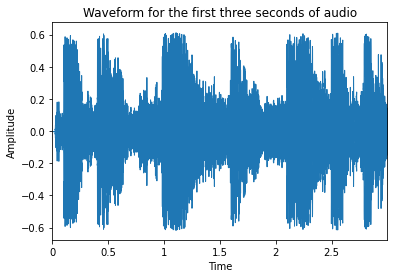

In [2]:
# Load will produce the waveform and the sample rate as an output.
example_source, example_sr = librosa.load(filepaths[1], sr=global_sr, duration=global_dur)

librosa.display.waveplot(example_source, sr=example_sr)
plt.ylabel("Amplitude")
plt.title("Waveform for the first three seconds of audio")
plt.show()

Some terminology: the _sample rate_ (`sr`) is a number (measured in Hz) telling us how many times per second the true audio waveform was measured.
High quality audio usually has a sample rate of 44.1 kHz. 
If the audio is mono then Librosa hands you a numpy array of length `sr * duration`, and if the audio is stereo it hands you a 
two dimensional numpy array of shape (2, `sr * duration`).

In [3]:
print(f'The sample rate of the example audio is {example_sr} and duration {librosa.get_duration(example_source)}. This leads to a numpy array of length {int(example_sr * librosa.get_duration(example_source))}.')
print(f'Numpy array shape: {example_source.shape}')

The sample rate of the example audio is 22050 and duration 3.0. This leads to a numpy array of length 66150.
Numpy array shape: (66150,)


The entries in this numpy array are exactly the amplitudes of the waveform. If you were just to plot the numpy array, you get
the same waveform plot but indexed by the sample location instead of time.

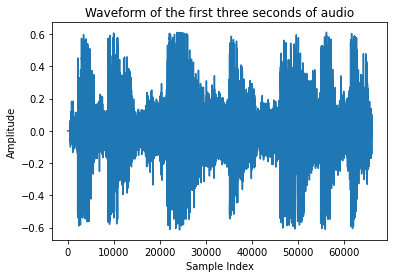

In [4]:
plt.plot(example_source)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of the first three seconds of audio')
plt.show()

Spectrograms are a different way of representing the information in a waveform. It selects out the frequencies of each chunk of audio 
using a Fourier transform. The result is a colorful image showing the intensity (dB) of each frequency over time. 
(This sometimes goes under the name of "Short-Time Fourier Transform," where a signal over an interval is subdivided into small chunks over subintervals and a Fourier transform is applied to each little chunk). 

A melspectrogram is essentially a spectrogram where the intensity of each frequency is logarithmically scaled and shifted. This brings the features of the audio closer together visually, which will help a lot in applying machine learning techniques. This can be thought of as a kind of normalization.

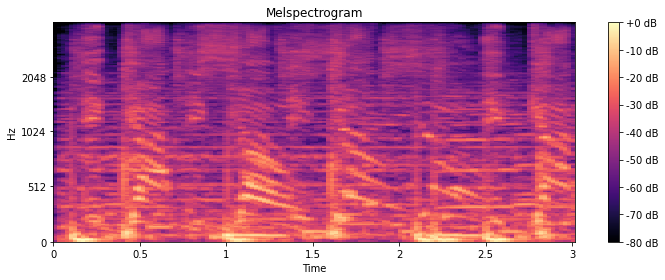

In [5]:
view_melspec(example_source, global_sr)

## How long does a typical load take?

Being a rather unfamiliar data type, it is good to get a sense of how much time it takes to load this data and how much memory it consumes by storing it.

On my 2013 Macbook Pro running Ubuntu, two seconds of audio takes about 384 ms to load. Since there are about 8000 songs in the small version of the FMA dataset, you can get an estimate for how long it would take to load every waveform in by multiplying 384 by 8 (the thousand cancels with the milli), which gives about 

In [6]:
print(f"Loading 2 seconds from all audio samples will take about {np.round(384* 8 /60, 2)} minutes.")

Loading 2 seconds from all audio samples will take about 51.2 minutes.


This is on an old macbook pro running a suboptimal operating system, so a newer computer may be able to handle this a lot better than my current one.

A challenge when working with audio data is that some files can be corrupted, and Librosa will return an error when loading them.
Rather than running through the entire dataset using `Librosa.load` we can instead use `torchaudio.info` which collects any metadata from the tracks without having to load each sample.

On my 2013 MBP this only takes about 150 microseconds, a dramatic improvement. The metadata preprocessing script uses this under the hood to check for integrity.

### On 2020 macbook

Takes about 23 ms on my new macbook. Great improvement!

## Estimating memory cost

This takes about 1.4 GB of memory to store all song audio.

## Dataframe management

Be sure to run `metadata_preprocess.py` before running this cell. This just loads the processed metadata as a tidy dataframe.

In [7]:
meta_path = os.path.join(".", "data", "fma_metadata", "meta_df.csv")

meta_df = pd.read_csv(
    os.path.join(meta_path), index_col=0
)

# get a list of the genres
genre_list = list(meta_df.genre.unique())
genre_dict = dict(zip(genre_list, range(len(genre_list))))

In [8]:
## check to make sure each path points to the right file
meta_df["track_id"].equals(meta_df["mp3_path"].apply(lambda x: int(id_from_path(x))))

True

In [9]:
meta_df.head()

,track_id,genre,mp3_path,duration,mel_path
0,2,Hip-Hop,/Users/andrewwray/Documents/projects/music_clf...,29.988571,./data/fma_small_melspecs/000002.npz
1,5,Hip-Hop,/Users/andrewwray/Documents/projects/music_clf...,30.014694,./data/fma_small_melspecs/000005.npz
2,10,Pop,/Users/andrewwray/Documents/projects/music_clf...,29.988571,./data/fma_small_melspecs/000010.npz
3,140,Folk,/Users/andrewwray/Documents/projects/music_clf...,29.988571,./data/fma_small_melspecs/000140.npz
4,141,Folk,/Users/andrewwray/Documents/projects/music_clf...,29.988571,./data/fma_small_melspecs/000141.npz


## Duration Analysis

Most songs in the FMA dataset are around 30 seconds in length.

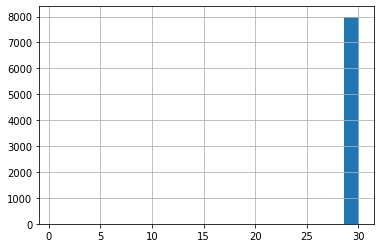

In [10]:
meta_df.duration.hist(bins=20)

However, there are a few that are very short.

In [11]:
meta_df.loc[(meta_df.duration < 28), :]

,track_id,genre,mp3_path,duration,mel_path
4423,98565,Hip-Hop,/Users/andrewwray/Documents/projects/music_clf...,1.645714,./data/fma_small_melspecs/098565.npz
4424,98567,Hip-Hop,/Users/andrewwray/Documents/projects/music_clf...,0.548571,./data/fma_small_melspecs/098567.npz
4425,98569,Hip-Hop,/Users/andrewwray/Documents/projects/music_clf...,1.567347,./data/fma_small_melspecs/098569.npz


I will be training models on samples at least 2 seconds long, so these will be dropped.

In [12]:
meta_df.drop(meta_df.loc[(meta_df.duration < 28), :].index, axis=0, inplace=True)

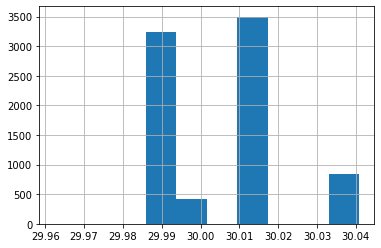

In [13]:
meta_df.duration.hist(bins=10)

## Encoding Genres

In [14]:
# encode genre column
if not set(genre_list).issubset(meta_df.columns):
    meta_df = attach_onehot_encoding(meta_df, "genre")

# EDA

The following cell picks a few melspectrograms at random to visualize.

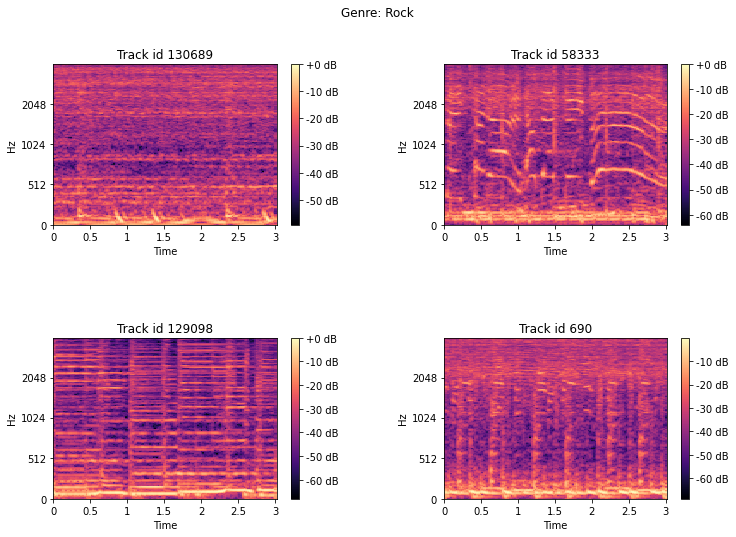

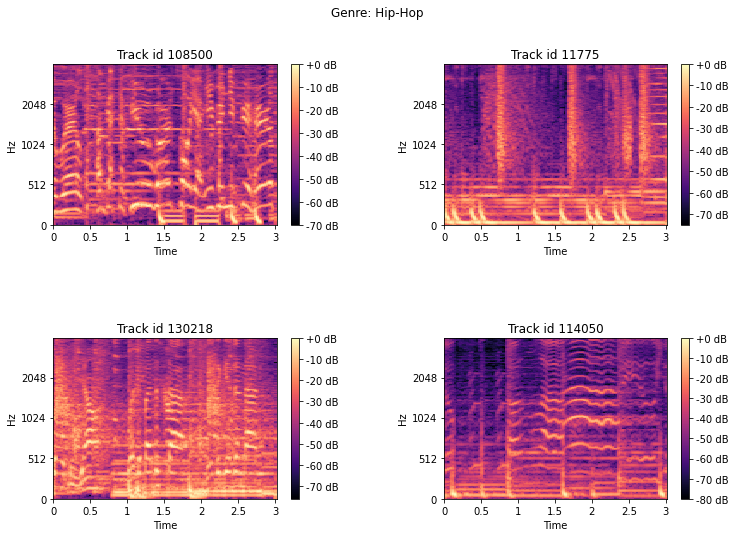

In [15]:
plot_sample("Rock", meta_df, nrow=2)
plot_sample("Hip-Hop", meta_df, nrow=2)

# Two genres

Now I will focus on training a classifier on two genres. This will be an easier task than trying to classify with all 8 genres, and it will use fewer resources.

In [28]:
input_shape = np.load(meta_df["mel_path"].iloc[0])["arr_0"].shape + (1,)

genre_sublist = ["Pop", "Hip-Hop"]

# This function selects out the genres in genre_sublist and applies a min-max scaler to each spectrogram.
X, y = subset_data(meta_df, genre_sublist, n_samples=1996) 

assert not np.any(np.isnan(X))
    
print(X.shape, y.shape)

#  Make the folders for the given models:
if not os.path.exists(two_genre_path:='./models/two_class/'):
    os.mkdir(two_genre_path)

track with id 119979 was non-standardizable. Dropping from dataset.
track with id 110736 was non-standardizable. Dropping from dataset.
(1994, 200, 130) (1994, 2)


## Logistic Regression

This is a simple model that serves as a test for the training code before going to harder models. 

Current goal: get hyperparameter tuning working.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Hyperparameters
HP_REG_PARAM = hp.HParam('regularization parameter', hp.RealInterval(0.001,1))

# Accuracy
METRIC_ACCURACY = 'accuracy'

# set up the file writer
with tf.summary.create_file_writer('logs/logistic_reg_hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_REG_PARAM],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [17]:
logreg_path = os.path.join(two_genre_path, "logreg/")
logistic_reg = MyModel(
    batch_size = 32,
    model_dir = logreg_path,
    genre_labels = genre_sublist,
    X_train = X[:1800, :, :],
    y_train = y[:1800,:],
    X_test = X[1800:, :, :],
    y_test = y[1800:,:]
)

In [32]:
logistic_reg_model = Sequential(
    [
        Flatten(input_shape=input_shape),
        Dense(
            2,
            activation="softmax",
            kernel_regularizer=regularizers.l2(0.01)
        ),
    ]
)

logistic_reg.attach_model(logistic_reg_model)
logistic_reg.summary()
logistic_reg.fit(num_epochs=50, verbose=0)
logistic_reg.plot_history()

NameError: name 'regularizers' is not defined

In [ ]:
def train_test_model(mymodel, model, hparams):
    

In [18]:
logistic_reg.load_model()
# logistic_reg.summary()
logistic_reg.evaluate(verbose=1, all=True)
logistic_reg.confusion_matrix()
logistic_reg.classification_report()

Training set
57/57 [==============================] - 0s 1ms/step - loss: 0.4989 - accuracy: 0.7694
Testing set
7/7 [==============================] - 0s 1ms/step - loss: 0.5245 - accuracy: 0.7371
[[80 19]
 [32 63]]
              precision    recall  f1-score   support

         Pop       0.71      0.81      0.76        99
     Hip-Hop       0.77      0.66      0.71        95

    accuracy                           0.74       194
   macro avg       0.74      0.74      0.74       194
weighted avg       0.74      0.74      0.74       194



With Pop and Hip-Hop as the only two genres the linear regression is surprisingly accurate with a ~75% test accuracy.

## 2D CNN

Next let's see how an ordinary CNN works.

In [19]:
input_shape

(200, 130, 1)

In [29]:
# convolutional chunk

def add_conv_chunk(model, num_filters, kernel_size, pool_size, drop_prob):
    """adds a convolutional chunk to the model.
    num_filters - integer, controls number of channels
    kernel_size - 2-tuple of ints
    pool_size - 2-tuple of ints
    drop_prob - float between 0 and 1
    """
    model.add(
        Conv2D(
            num_filters,
            kernel_size=kernel_size,
            activation="relu", 
            data_format="channels_last"
        )
    )
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_prob))
            

def create_cnn(num_genres=2, num_filters=40, input_shape=input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    add_conv_chunk(model,
                   num_filters=num_filters,
                   kernel_size=(3,3),
                   pool_size=(2,2),
                   drop_prob=0.2
                  )
    
    add_conv_chunk(model,
                   num_filters=num_filters,
                   kernel_size=(3,3),
                   pool_size=(2,2),
                   drop_prob=0.2
                  )
    
    add_conv_chunk(model,
                   num_filters=num_filters,
                   kernel_size=(3,3),
                   pool_size=(2,2),
                   drop_prob=0.2
                  )
      
    model.add(Flatten())
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.0001)))
    model.add(Dense(num_genres, activation="softmax"))

    return model

In [30]:
conv_net_path = os.path.join(two_genre_path, "convnet/")
conv_net = MyModel(
    batch_size = 64,
    model_dir = conv_net_path,
    genre_labels = genre_sublist,
    X_train = X[:1800, :, :, np.newaxis],
    y_train = y[:1800, :],
    X_test = X[1800:, :, :, np.newaxis],
    y_test = y[1800:, :]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 128, 40)      400       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 64, 40)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 99, 64, 40)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 62, 40)        14440     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 31, 40)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 48, 31, 40)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 29, 40)       

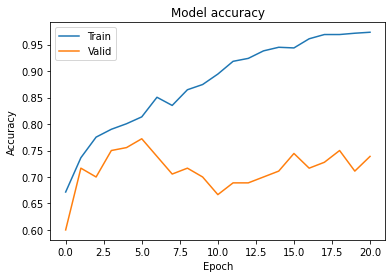

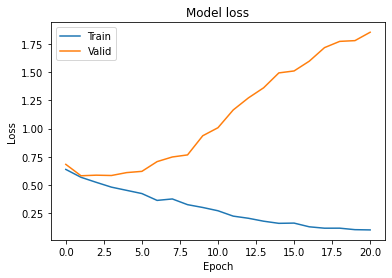

<Figure size 432x288 with 0 Axes>

In [31]:
conv_net_model = create_cnn()

conv_net.attach_model(conv_net_model)
conv_net._compile()
conv_net.summary()
conv_net.fit(num_epochs=50, verbose=1)
conv_net.plot_history()

In [23]:
conv_net.load_model()
conv_net.summary()
conv_net.confusion_matrix()
conv_net.classification_report()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 128, 20)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 64, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 64, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 62, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 31, 20)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 31, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 29, 20)        3

## CRNN

In [24]:
def create_crnn(
    num_genres=8,
    input_shape=input_shape,
    drop_prob=0.2,
    lstm_count=100,
    n_hidden=64,
    n_layers=4,
    conv_filter_count=64,
):
    model = Sequential()
#     model.add(Reshape((input_shape[0], input_shape[1]), input_shape=input_shape))

    # 1D convolutional layers
    for i in range(n_layers):
        model.add(
            Conv1D(
                filters=conv_filter_count,
                kernel_size=4,
                activation="relu",
                kernel_regularizer=l2(0.001),
                name="convolution_" + str(i + 1),
            )
        )
        model.add(BatchNormalization(momentum=0.9))
        model.add(MaxPooling1D(2))
        model.add(Dropout(drop_prob))

    # LSTM layer

    model.add(LSTM(lstm_count, return_sequences=False))
    model.add(Dropout(drop_prob))

    # Dense layer
    model.add(Dense(n_hidden, kernel_regularizer=l2(0.001), name="dense1"))
    model.add(Dropout(drop_prob))

    # softmax output
    model.add(Dense(num_genres))
    model.add(Activation("softmax", name="output_layer"))

    return model

In [25]:
crnn_path = os.path.join(two_genre_path, "crnn/")
crnn = MyModel(
    batch_size = 32,
    model_dir = crnn_path,
    genre_labels = genre_sublist,
    X_train = X[:1800, :, :],
    y_train = y[:1800, :],
    X_test = X[1800:, :, :],
    y_test = y[1800:, :]
)

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6691
Epoch 00001: val_accuracy improved from -inf to 0.69444, saving model to ./models/two_class/crnn/model.h5
51/51 [==============================] - 2s 49ms/step - loss: 0.9607 - accuracy: 0.6691 - val_loss: 0.9462 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.8799 - accuracy: 0.7407
Epoch 00002: val_accuracy did not improve from 0.69444
51/51 [==============================] - 2s 36ms/step - loss: 0.8799 - accuracy: 0.7407 - val_loss: 0.9058 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.7741
Epoch 00003: val_accuracy improved from 0.69444 to 0.70556, saving model to ./models/two_class/crnn/model.h5
51/51 [==============================] - 2s 34ms/step - loss: 0.8021 - accuracy: 0.7741 - val_loss: 0.8947 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 4/50
51/51 [=

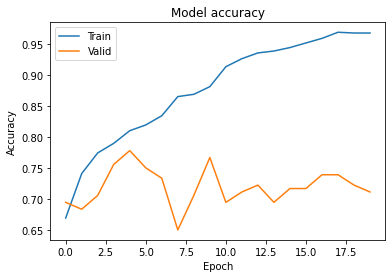

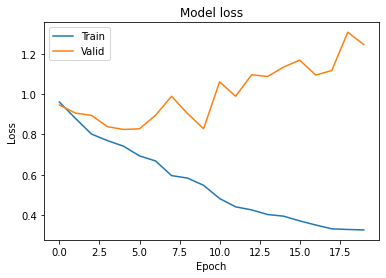

<Figure size 432x288 with 0 Axes>

In [26]:
crnn_model = create_crnn(num_genres=2)

crnn.attach_model(crnn_model)
crnn._compile()
crnn.fit(num_epochs=50, verbose=1)
crnn.summary()
crnn.plot_history()

In [27]:
crnn.load_model()
crnn.confusion_matrix()
crnn.classification_report()

[[59 40]
 [17 78]]
              precision    recall  f1-score   support

         Pop       0.78      0.60      0.67        99
     Hip-Hop       0.66      0.82      0.73        95

    accuracy                           0.71       194
   macro avg       0.72      0.71      0.70       194
weighted avg       0.72      0.71      0.70       194

